In [1]:
import time
import os
import nltk
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline


In [12]:
ran_state = 42

current_dir = os.getcwd()
data_dir = f'{current_dir}/dataset'
dl_folder = f'{current_dir}/dataset/dl'
destination_folder = f'{current_dir}/results'
filenames = [
    'kant.txt', 
    'aristotle.txt', 
    'plato.txt', 
    'hume.txt',
    'nietzsche.txt'
    ]

[os.path.join(data_dir, file) for file in filenames]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
from load_data import LoadData

corpus = LoadData(n_max=1000)
corpus.load()
philo_df = corpus.corpus
philo_df = philo_df[['sentence', 'label', 'author', 'tok_lem_sentence']]

philo_df.head()

,sentence,label,author,tok_lem_sentence
0,"Nay suppose we coued draw an inference, it wou...",1,Hume,"[nay, suppose, coued, draw, inference, would, ..."
1,"For to know this is true wisdom and virtue, an...",2,Plato,"[know, true, wisdom, virtue, ignorance, manife..."
2,This is the testimony of pleasure of which all...,4,Nietzsche,"[testimony, pleasure, religion, proud, althoug..."
3,And all that is now to be at an end?,4,Nietzsche,[end]
4,"xi., Bohns Translation.... In engaging in war ...",0,Kant,"[bohns, translation, engaging, war, ought, mak..."


In [14]:
enc_aut = {}
aut_label = philo_df[['author', 'label']].drop_duplicates().reset_index(drop=True).to_dict('record')
for k in aut_label:
    enc_aut[k['label']] = k['author']
enc_aut    

/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


{1: 'Hume', 2: 'Plato', 4: 'Nietzsche', 0: 'Kant', 3: 'Aristotle'}

sentence            0
label               0
author              0
tok_lem_sentence    0
dtype: int64


/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


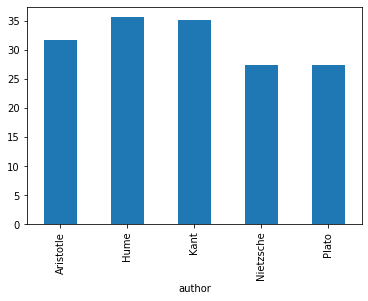

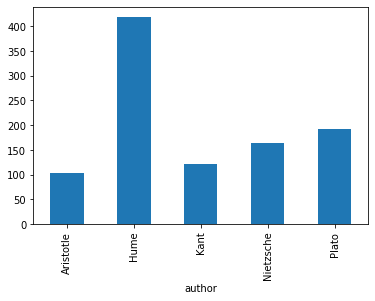

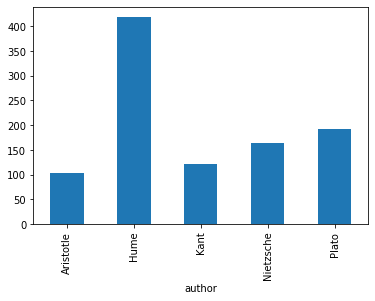

author
Aristotle    3
Hume         1
Kant         0
Nietzsche    4
Plato        2
Name: label, dtype: int64

In [15]:
df_nan = philo_df.isna()
print(df_nan.sum())

# print(philo_df.describe())

philo_df['word_count'] = philo_df['sentence'].apply(lambda x: x.count(' '))


philo_df.groupby('author')['word_count'].mean().plot.bar()
plt.show()
philo_df.groupby('author')['label'].count().plot.bar()
plt.show()

philo_df.groupby('author')['label'].size().plot.bar()
plt.show()

philo_df.groupby('author')['label'].mean()

In [16]:
train_test_ratio = 0.80
train_valid_ratio = 0.80
df_train, df_test = train_test_split(philo_df, train_size = train_test_ratio, random_state = ran_state)
df_train, df_val = train_test_split(philo_df, train_size = train_valid_ratio, random_state = ran_state)

# Write preprocessed data
df_train.to_csv(dl_folder + '/train.csv', index=False)
df_val.to_csv(dl_folder + '/val.csv', index=False)
df_test.to_csv(dl_folder + '/test.csv', index=False)

In [17]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [18]:
import spacy 

BATCH_SIZE = 32 

spacy_en = spacy.load("en_core_web_sm")
def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

def generate_bigrams(seq):
    """
    Add bigrams after 1-gram tokens.
    >>> generate_bigrams(['This', 'film', 'is', 'terrible'])
    >>> ['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']
    """
    n_grams = set(zip(*[seq[i:] for i in range(2)]))
    for n_gram in n_grams:
        seq.append(' '.join(n_gram))
    return seq

# Create Fields
LABEL = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
TEXT = Field(sequential=True, tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  preprocessing = generate_bigrams, include_lengths=True, batch_first=True)
fields = [('sentence', TEXT), ('author', LABEL)]

# Create TabularDataset
train_data, valid_data, test_data = TabularDataset.splits(path=dl_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

print('First instances for training {text, label}', vars(train_data[3]))

/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Ple

First instances for training {text, label} {'sentence': ['When', 'he', 'had', 'bathed', ',', 'and', 'his', 'children', 'were', 'brought', 'to', 'him', ',', 'and', 'the', 'women', 'belonging', 'to', 'his', 'family', 'were', 'come', ',', 'having', 'conversed', 'with', 'them', 'in', 'the', 'presence', 'of', 'Crito', ',', 'and', 'given', 'them', 'such', 'injunctions', 'as', 'he', 'wished', ',', 'he', 'directed', 'the', 'women', 'and', 'children', 'to', 'go', 'away', ',', 'and', 'then', 'returned', 'to', 'us', '.', ', having', 'then returned', 'family were', 'were brought', 'come ,', 'them in', 'and then', 'brought to', 'the women', 'he wished', 'he directed', 'returned to', 'to his', 'away ,', ', and', 'his children', 'to go', 'bathed ,', 'given them', 'us .', 'women and', 'go away', 'children were', 'children to', 'women belonging', 'conversed with', 'and children', 'and the', 'with them', 'them such', 'to us', ', he', 'he had', 'were come', 'Crito ,', 'and given', 'directed the', 'such i

In [19]:
# Vocabulary
# text_field.build_vocab(train, min_freq=3)

# We build the vocab with glove 6b embedding
# It generates embedding from string
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [20]:
# To do try animal and city name
# Retrieve the vector for dog
TEXT.vocab.vectors[TEXT.vocab.stoi['Paris']]

tensor([ 0.8361,  0.0741,  0.4035,  0.9052,  0.9093, -0.9562,  0.4209, -3.0193,
        -0.4904,  0.8428, -1.3858,  0.3815,  0.3563, -0.2995, -0.6272, -1.1421,
         1.3801,  1.9051, -1.6055,  0.9271,  0.0549,  0.3111, -1.0512, -1.4214,
         1.4088,  0.7820, -1.0420,  0.3987, -1.4779,  0.4008,  0.8786,  0.4321,
        -1.7822,  0.6221, -0.0068, -0.7846,  0.2271,  0.0166, -0.3770,  0.5286,
        -0.2253,  0.4584,  0.0371, -0.3824, -1.1905, -0.2926,  1.9259, -0.6985,
        -0.3428,  0.9361, -0.4678,  1.5222,  0.4198, -1.1068,  0.4686, -0.0953,
        -1.2238,  0.4531, -0.4026,  0.7346,  1.6088,  0.6045,  1.7433, -1.8400,
        -0.1446, -0.0592,  0.7178, -0.0487,  0.8786,  1.9768,  0.1268, -0.1412,
         0.7519,  1.0235,  1.8326,  0.1836, -1.4087, -0.7043, -0.0641, -0.7196,
         0.1921, -1.3827, -0.3775, -0.9951,  0.3862,  0.0821, -0.2431, -1.2590,
         0.9977,  0.7609,  2.3067,  0.8580,  0.8785, -1.7842, -1.4248,  1.4945,
         0.6284, -0.3802, -0.0185,  1.05

In [21]:
# Display frequency, wordindex and 
# vector for each word respectively of the 
print(TEXT.vocab.freqs[1])
# stoi gives access to a dictionnary containing word and their indexes
print(TEXT.vocab.stoi[1])
print(TEXT.vocab.vectors[1])

0
0
tensor([-1.6614,  1.1545, -0.9539,  1.5112,  1.2421, -1.2255, -0.3273, -0.7928,
         0.1389,  1.0507,  0.6977, -0.9729,  0.3348,  0.3781, -0.2271, -0.9677,
         0.4873,  0.5258,  0.7060,  0.7559, -1.6422,  1.2089,  1.7998, -0.3703,
        -0.7985, -0.3633, -0.5790,  0.7280, -0.3867, -0.9491, -0.3187,  1.1952,
        -0.0409,  1.0870, -0.1299, -0.6890,  0.6349,  1.8065,  0.5650,  0.4353,
         0.4575,  1.2969, -0.4133,  0.3201, -0.8715,  1.2667, -0.4072, -1.2192,
        -1.1033, -0.0458, -0.1512,  0.3465,  0.9425,  0.2403, -1.3882, -1.0304,
         0.2646, -0.2421,  0.6515,  0.9840,  0.1514, -2.3562, -0.4326,  1.2781,
         0.9605,  0.3671, -0.9989, -0.2501, -0.5505, -0.5285,  0.5271, -1.3253,
         0.6040,  1.4566, -1.1941,  0.5740,  1.2820, -0.8345,  0.6322,  0.0383,
         1.2307,  0.3444, -1.8191, -0.3241, -0.6964, -0.0823,  0.6648, -0.9254,
        -0.3084,  0.6984,  0.0979,  0.3449,  0.7896,  0.2754, -0.9191, -1.0275,
        -2.2898,  1.2764,  0.0129, -

In [22]:
BATCH_SIZE = 32

# Create Iterators
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=lambda x: len(x.sentence),
    sort=False,
    shuffle=True,
    batch_size = BATCH_SIZE, 
    device = device)

batch = next(iter(train_iterator))
print('next batch instance according to their respective field', batch, batch.sentence, batch.label)
for data in valid_iterator:
    (x, x_len), y = data.sentence, data.label
    print(x, x_len, y)
    break

/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


AttributeError: 'Batch' object has no attribute 'label'

In [73]:
# Training 
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [74]:
class LSTM(nn.Module):

#     def __init__(self, dimension=128):
    def __init__(self, vocab_size,
                 embedding_dim, hidden_dim,
                 output_dim,
                 n_layers, 
                 bidirectional,
                 dropout,
                 pad_idx):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim,
                                      padding_idx = pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=bidirectional,
                           dropout=dropout)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.hidden_size]
        out_reverse = output[:, 0, self.hidden_size:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [75]:
# Training Function

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # first layer is the embedded layer that uses 100 length vectors to represent each word.
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab) # To check
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


In [76]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([25002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.6971, -0.8865,  0.7625,  ..., -0.2578, -2.3295, -0.9226],
        [ 0.5935, -1.2607, -1.2701,  ..., -2.2648,  1.4020,  2.2614],
        [-0.8253, -0.2917, -0.4031,  ..., -0.7828, -0.1828, -1.0616]])


In [169]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tqdm 

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def fit(model, it, is_eval=False, optim=None, crit=None):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0; epoch_rec = 0; epoch_f1 = epoch_prec
    if is_eval:
        model.eval()
    else:
        model.train()
    for batch in tqdm.tqdm(it, total=len(it)):
        if not is_eval:
            optim.zero_grad()
        text, text_lenghts = batch.sentence
        text = text.type(torch.LongTensor)
        is_null = text_lenghts==0
        if True in is_null: # TO FIX
            print(text, text_lenghts)
            continue
        preds = model(text, text_lenghts)
        loss = crit(preds, batch.label)
        acc = accuracy_score(batch.label.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1))
        if not is_eval:
            loss.backward()
            optim.step()
        else:
            prec, recall, f1, _ = precision_recall_fscore_support(batch.label.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1), average='weighted')
            epoch_prec += prec
            epoch_rec += recall
            epoch_f1 += f1
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(it), epoch_acc / len(it), epoch_prec / len(it), epoch_rec /len(it), epoch_f1 / len(it)


import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [40]:
def train(model,
          optimizer,
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc, _ = fit(model, train_iterator, is_eval=False,
                                    optim=optimizer, crit=criterion)
        valid_loss, valid_acc, val_prec, val_rec, val_f1 = fit(model, valid_iterator, is_eval=True,
                                         crit=criterion)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')
       
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print(f'\t Val. Pre: {val_prec:.3f} |  Val. Rec: {val_rec*100:.2f}% | Val. F1: {val_f1*100:.2f}%')

    # Last model
    torch.save(model.state_dict(), 'tut2-model.pt')
    print('Finished Training!')


# train(model=model, optimizer=optimizer, num_epochs=10)

NameError: name 'train_iter' is not defined

In [320]:
# torch.save(model.state_dict(), 'tut2-model.pt')

In [ ]:
# Evaluate

In [170]:
# Evaluate
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc, test_prec, test_rec, test_f1 = fit(model, test_iterator, crit=criterion, is_eval=True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print(f'Test prec: {test_prec:.3f} | Test rec: {test_rec*100:.2f}% | Test f1: {test_f1*100:.2f}%')



100%|██████████| 335/335 [01:06<00:00,  5.01it/s]

Test Loss: 1.630 | Test Acc: 39.30%
Test prec: 0.370 | Test rec: 39.30% | Test f1: 35.68%


In [ ]:
# Predict

In [209]:
# glove embed
# from torchtext.vocab import GloVe
# embedding_glove = GloVe(name='6B', dim=100)
import random 

def generate_sentence(n):
    sample = philo_df[['sentence', 'author']].iloc[n%len(philo_df)]
    return sample.sentence, sample.author

def predict(model, sentence):
    model.eval()
    # split one sentence into list of words (smartly splitted by spacy)
    tokenized = generate_bigrams([tok.text for tok in spacy_en.tokenizer(sentence)])
    # Embedded with Glove
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    # Prepare input
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).transpose(0,1)
    length_tensor = torch.LongTensor(length)
    out = model(tensor, length_tensor)
    out = np.argmax(out.cpu().detach().numpy(), axis=1)[0]
    author_label = LABEL.vocab.stoi[str(out)]
    author_label = enc_aut[author_label]
    return author_label
sentence_ex, label_ex = generate_sentence(random.randint(0, len(philo_df)))
print(sentence_ex, '\n', label_ex)
print('Prediction:', predict(model, sentence_ex))


the difficulti on thi head must encreas when we consid that our judgment alter veri sensibl accord to the subject and that the same power and proxim will be deem possess in one case which is not esteem such in anoth 
 Hume
Prediction: Aristotle


In [164]:
preds =  [[0.48278892, 0.4991066,  0.5182273,  0.50137734, 0.5032032,  0.50438505],
[0.48278892, 0.4991066,  0.5182273,  0.50137734, 0.5032032,  0.50438505]]
np.argmax(preds, axis=1)

array([2, 2])

In [180]:
philo_df[['sentence', 'author']].iloc[2]

sentence    i shall therefor ventur to acknowledg that not...
author                                                   Hume
Name: 23620, dtype: object

In [287]:
len(train_iterator)

3

In [183]:
print(LABEL.vocab.stoi, enc_aut)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fdebe9f5160>>, {'<unk>': 0, '1': 1, '2': 2, '4': 3, '0': 4, '3': 5, 1: 0, 3: 0, '[4]': 0, '[1]': 0}) {1: 'Hume', 2: 'Plato', 4: 'Nietzsche', 3: 'Aristotle', 0: 'Kant'}
